In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
seed = 0
np.random.seed(seed)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'whitegrid')

#!pip install twint
# import twint
import nest_asyncio
nest_asyncio.apply()


import datetime as dt
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from wordcloud import WordCloud

# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
# from keras.models import Sequential
# from keras.layers import Embedding, Dense, Dropout, LSTM
# from keras.optimizers import Adam, RMSprop, SGD
# from keras.callbacks import EarlyStopping
# from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
# from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [2]:
tweets = pd.read_csv('labeling1.csv')
tweets

,created_at,text_clean,text_preprocessed,polarity,polarity_score
0,2022-04-23T23:15:31.000Z,zelensky kembali menyerukan untuk pertemuan de...,zelensky kembali seru untuk temu dengan putin ...,negative,-0.752306
1,2022-04-23T22:54:40.000Z,zelenskyy berjanji lawan invasi rusia nhk wor...,zelenskyy janji lawan invasi rusia nhk worldja...,negative,-0.815056
2,2022-04-23T22:41:21.000Z,bbm naik dampak invasi rusia ke ukraina budi m...,bbm naik dampak invasi rusia ke ukraina budi m...,negative,-1.848306
3,2022-04-23T21:29:50.000Z,tidak aktif bulan yang lalu terakhir baru upl...,tidak aktif bulan yang lalu akhir baru upload ...,negative,-1.821722
4,2022-04-23T21:16:39.000Z,invasi rusia ke ukraina dimulai tanggal febru...,invasi rusia ke ukraina mulai tanggal februari...,negative,-2.817861
...,...,...,...,...,...
17852,2022-03-21T15:02:40.000Z,anonymous menyerang sebagai pembalasan atas in...,anonymous serang bagai balas atas invasi rusia...,negative,-0.647694
17853,2022-03-21T14:39:22.000Z,invasi belum berhasil apa saja kesalahan rusia,invasi belum hasil apa saja salah rusia,negative,-1.943639
17854,2022-03-21T14:27:35.000Z,uni eropa berencana meninggalkan pasokan minya...,uni eropa rencana tinggal pasok minyak dan gas...,neutral,0.436083
17855,2022-03-21T14:26:34.000Z,amerika siap bantu china investigasi boeing y...,amerika siap bantu china investigasi boeing ya...,negative,-2.023667


In [3]:
tweets['polarity'].value_counts()

negative    15589
neutral      1429
positive      839
Name: polarity, dtype: int64

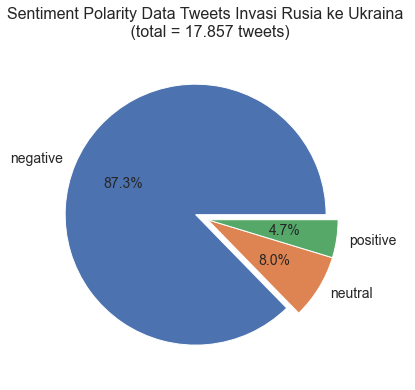

In [4]:
fig, ax = plt.subplots(figsize = (6, 6))
sizes = [count for count in tweets['polarity'].value_counts()]
labels = list(tweets['polarity'].value_counts().index)
explode = (0.1, 0, 0)
ax.pie(x = sizes, labels = labels, autopct = '%1.1f%%', explode = explode, textprops={'fontsize': 14})
ax.set_title('Sentiment Polarity Data Tweets Invasi Rusia ke Ukraina \n (total = 17.857 tweets)', fontsize = 16, pad = 20)
plt.show()


In [5]:
pd.set_option('display.max_colwidth', 3000)
positive_tweets = tweets[tweets['polarity'] == 'positive']
positive_tweets = positive_tweets[['text_preprocessed', 'polarity_score', 'polarity']].sort_values(by = 'polarity_score', ascending=False).reset_index(drop = True)
positive_tweets.index += 1
positive_tweets[0:30]

,text_preprocessed,polarity_score,polarity
1,harga minyak bisa lihat dari sudut pandang produsenagen yang nimbun minyak misal dan sudut pandang konsumen yang kena dampak dari harga minyak yang mahal hargaharga barang pokok yang suka naik jelang bulan puasa atau dampak invasi rusia ke ekonomi,6.953111,positive
2,enam ekor singa enam ekor harimau dua ekor kucing liar dan satu ekor anjing liar evakuasi dari dekat ibu kota kiev ke kebun binatang poznan di polandia,6.155583,positive
3,apa hubung iya invasi rusia ke ukraina dengan harga minyak goreng yang mahal produksi minyak kelapa sawit di indonesia cukup banyak pabrik olah minyak kelapa sawit di indonesia cukup banyak klau boleh bilang hasil produksi minyak goreng lebih dari cukup,5.978194,positive
4,telah kecele akibat jebak informasi intel russia dulu belum invasi yang kata gak ken serang tapi nyata beneran serang dan ngediskon informasi intel us yang dulu bilang bakal ada serang tapi anggap isu bohong sekarang apa informasi intelijen dari rusia ini yang mesti diskon,5.709028,positive
5,dari seluruh warga negara yang kembali ke tanah air ada pmi yang turut evakuasi diri dari perempuan dan satu lakilaki mayoritas asal dari bal dan kerja bagai terap di ukraina jelas,5.696333,positive
6,kita harus paham bahwa di kepala putin perang bukan dengan ukraina dia perang dengan amerika serikat dan nato kata khodorkovsky dia kata ini lebih dari sekali,5.675694,positive
7,minyak mentah naik pada level barrel karena yang masih timbang larang minyak akibat dan prospek minta minyak luar ekspektasi dari sehingga pengaruh minta dan sedia minyak yang ada,5.658472,positive
8,harus narasi bukan dukung dukung tapi cara untuk sikap invasi tersebutjika narasi dukung dukung iya sama saja bentuk dua persepsi pasti ada yang dukung rusia atau ukraina akhir bentuk dua kubu pecah lagi deh,5.651361,positive
9,invasi rusia ini kembali minat sarjana hai yang kini kerja sudah kesana kemari ke dalam topik hubung internasionaldeep inside meski ada yang lagi jual cokelat jadi hubungan masyarakat rs kerja agency hingga anggur profesional tetap tarik dengan isu hai,5.585139,positive
10,hai ada yang lagi sering bicara ini di bulan februari lalu apalagi kalau bukan tentang invasi rusia hadap ukraina kenapa kok bisa ada serang sih di issue of the month ini kita akan bahas tentang konflik ini lebih lanjut iya gengs,5.519194,positive


In [6]:
pd.set_option('display.max_colwidth', 3000)
negative_tweets = tweets[tweets['polarity'] == 'negative']
negative_tweets = negative_tweets[['text_clean', 'polarity_score', 'polarity']].sort_values(by = 'polarity_score', ascending=True)[0:10].reset_index(drop = True)
negative_tweets.index += 1
negative_tweets[0:10]

,text_clean,polarity_score,polarity
1,invasi ke rusia dikcam barat invasi israel ke palestina barat diam rusiaamp paleatina jdi korban ketidak adilan blok barat pntas knpa rusia bela negara uni emirat arab turky iran irak dll krn senasib dg rusia mknya negara blok timur uni emirat arab turky dll btuh rusia jdi pembela,-14.106972,negative
2,sajak situ yang salah bicara tapi ngotot lagi gunakan logika ukraina tidak mau patuh pada rusia sebab yang berkuasa sana adalah diktator putin tuduhan ekstrim kanan pada zelenki adalah fitnah sebab ukraina negara demokrasi justru putin adalah neo nazi sebenarnya yang suka invasi,-13.012833,negative
3,invasi rusia ke ukraina sepertiga negara dunia yg tergabung di pbb dan nato memberikan sanksi yg berat sangat kepada rusia termasuk indonesia ddlm sanksi itu setuju namun invasi israel ke palestina pbb nato dimana sanksinya terhadap israel seberat sanksi rusia,-12.637667,negative
4,kwaci rusia ga akan kehabisan tentara utk invasi rusia ini urusan kedaulatan antara rusia dan ukraina posisi chechnya dimana untungnya apa ikutan invasi tentara muslim chechnya banyak yg tewas sia mengurangi populasi laki muslim dinegaranya sendiri mrk mati jihad bela org kafir,-11.860472,negative
5,negara barat mmg susah bersikap adil yakni jatuhkan sanksi dan embargo ke rusia akibat invasi ke ukraina dulu saat amerika invasi irak dan afghanistan gak ada tuh embargo dan sanksiakibat invasi rusia dan embargo tss bikin kacau ekonomi global yg rugikan banyak negara,-11.859417,negative
6,lfc jadi bet roman ini deket sama russian gov karena rusia invasi ukraina negaranegara blok barat ngambil keputusan sanksi ekonomi amp politik buat rusiajadi yang disanksi adalah roman chelsea adalah asset dan sanksi buat roman adalah assetnya dibekukan,-11.845250,negative
7,rusia adalah negara demokrasi multi partai partai yang berkuasa adalah partai rusia bersatu pimpinan putin dan partai komunis rusia itu oposisi partai komunis rusia juga menentang invasi rusia ke ukrania,-11.401889,negative
8,berita yg masuk di indo kebanyakan hoaxnya disamping itu banyak masuk berita barat yg nggiring opini nyudutin rusia spt banyak korban berjatuhan krn invasi rusia padahal ma rusia nyerangnya militer bukan warga sipil,-11.287000,negative
9,banyak orang di banyak negara mengutuk invasi rusia ke ukraina tidak salah memang tidak seorangpun yang ingin menjalani kehidupannya dalam situasi perang tapi apakah orangorang di banyak negara tersebut lupa bahwa tahun sudah apartheid israel menginvasi palestina,-11.123222,negative
10,pasti ada negara barat skg punya kesempatan utk mengkerdilkan rusia secara logika target mereka dgn invasi ini adalah menyingkirkan putin sehingga di rusia pecah ketidak pastian politik dan bukan tdk mungkin rusia di pecah lg menjd negara yg lbh kecil lagi dan x,-10.936389,negative


In [7]:
pd.set_option('display.max_colwidth', 3000)
negative_tweets = tweets[tweets['polarity'] == 'neutral']
negative_tweets = negative_tweets[['text_clean', 'polarity_score', 'polarity']].sort_values(by = 'polarity_score', ascending=True)[0:10].reset_index(drop = True)
negative_tweets.index += 1
negative_tweets[0:10]

,text_clean,polarity_score,polarity
1,tentara berhasil mempertahankan negaranya dr invasi sudah genap sebulan,0.000972,neutral
2,evakuasi dilakukan sebagai akibat dampak invasi rusia terhadap ukraina yang belum mereda hingga saat ini,0.001750,neutral
3,evakuasi terhadap pmi dilakukan sebagai akibat dampak invasi rusia terhadap ukraina yang belum mereda hingga saat ini,0.001750,neutral
4,dan evakuasi dilakukan sebagai akibat dampak invasi rusia terhadap ukraina yang belum mereda hingga saat ini rhamdani,0.001750,neutral
5,tegaskan dukung ukraina erdogan telepon biden untuk bahas invasi rusia detik media informasi,0.002306,neutral
6,update hari ke invasi ibu kota ukraina dihujani rudal rusia,0.005083,neutral
7,sejak rusia ke ukraina banyak orang mengenakan kuningbiru untuk menunjukan solidaritas kepada ukraina perang mengakibatkan peluncuran pesawat ruang angkasa tertunda dan kontrak batal,0.005472,neutral
8,astaga gegara invasi rusia ke ukraina pesawat terbesar di dunia hancurbaca selengkapnya,0.005778,neutral
9,jelang dua bulan invasi rusia uji rudal balistik antarbenua mampu jelajahi km,0.006139,neutral
10,sebulan invasi rusia sebulan pula perlawanan yang dilakukan ukraina mesin perang kremlin seperti tank baja dibikin hancur tak berfungsi jadi besi kiloan,0.006306,neutral
